https://towardsdatascience.com/image-recognition-with-machine-learning-on-python-image-processing-3abe6b158e9a

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_tuner as kt

2023-02-01 05:47:00.660462: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory
# https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
# https://datascience.stackexchange.com/questions/113449/what-does-shuffle-and-seed-parameter-in-keras-image-gen-flow-from-directory-si

data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/'

generator_train = ImageDataGenerator(validation_split=0.1,
                                     rescale=1/255.,
                                     rotation_range=5,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1)

train_ds = generator_train.flow_from_directory(
    data_dir+'train',
    target_size=(128,128),
    batch_size=32,
    class_mode='binary',
    subset='training',
    color_mode='rgb',
    shuffle=True,
    seed=0)

val_ds = generator_train.flow_from_directory(
    data_dir+'train', # same directory as training data
    target_size=(128,128),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    color_mode='rgb',
    shuffle=True,
    seed=0)

generator_test = ImageDataGenerator(rescale=1/255.)

test_ds = generator_test.flow_from_directory(
    data_dir+'test',
    target_size=(128,128),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False)

Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
print(pd.Series(train_ds.classes).value_counts().sort_index())
print(pd.Series(val_ds.classes).value_counts().sort_index())
print(pd.Series(test_ds.classes).value_counts().sort_index())

0    1207
1    3488
dtype: int64
0    134
1    387
dtype: int64
0    234
1    390
dtype: int64


In [5]:
print(train_ds.class_indices)

{'NORMAL': 0, 'PNEUMONIA': 1}


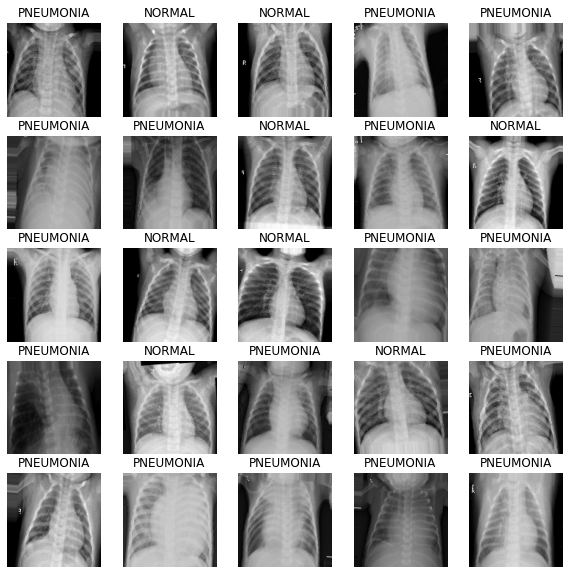

In [6]:
#https://www.tensorflow.org/tutorials/keras/classification
import matplotlib.pyplot as plt

X_train, y_train = next(train_ds)

plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(X_train[i])
    label = 'NORMAL' if int(y_train[i]) == 0 else 'PNEUMONIA'
    plt.title(label)
    plt.axis("off")

In [7]:
# https://pythonprogramming.net/keras-tuner-optimizing-neural-network-tutorial/
# https://towardsdatascience.com/hyperparameter-tuning-with-keras-tuner-283474fbfbe

# https://www.tensorflow.org/tutorials/load_data/images
# https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

from keras_tuner import HyperModel
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

class MyHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Conv2D(filters=hp.Int('input_units',
                             min_value=32,
                             max_value=128,
                             step=32),
                             kernel_size=(3, 3),
                             input_shape=(128,128,3),
                            activation='relu'))
        
        model.add(MaxPooling2D((2,2)))
         
        model.add(Conv2D(filters=hp.Int('input_units',
                             min_value=32,
                             max_value=128,
                             step=32),
                             kernel_size=(3, 3),
                            activation='relu'))

    
        model.add(MaxPooling2D((2,2)))
        
        model.add(Conv2D(filters=hp.Int('input_units',
                             min_value=32,
                             max_value=128,
                             step=32),
                             kernel_size=(3, 3),
                            activation='relu'))

    
        model.add(MaxPooling2D((2,2)))

        model.add(Flatten())
        
        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
        
        model.compile(optimizer='RMSprop',
                      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                      metrics=['accuracy', tf.keras.metrics.AUC(curve='PR', name='AUCPR')],
                      weighted_metrics=['accuracy', tf.keras.metrics.AUC(curve='PR', name='AUCPR')])
        
        return model

In [8]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=[0,1], y=train_ds.labels)
class_weights = dict(enumerate(class_weights))
val_sample_weights = class_weight.compute_sample_weight('balanced',val_ds.labels)

In [9]:
# https://medium.com/geekculture/how-to-plot-model-loss-while-training-in-tensorflow-9fa1a1875a5

class LogCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

In [10]:
# https://keras.io/api/keras_tuner/tuners/base_tuner/#tuner-class

log_callback = LogCallback()
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
hypermodel = MyHyperModel()
tuner_rs = kt.RandomSearch(
            hypermodel,
            objective=kt.Objective("val_weighted_AUCPR", direction="max"),
            seed=0,
            max_trials=1,
            executions_per_trial=1)

with tf.device('/GPU:0'):
    tuner_rs.search(train_ds,
                    epochs=10,
                    verbose=1,
                    validation_data=val_ds,
                    class_weight=class_weights,
                    callbacks=[log_callback, early_stop_callback])

Trial 1 Complete [00h 11m 01s]
val_weighted_AUCPR: 0.9952291250228882

Best val_weighted_AUCPR So Far: 0.9952291250228882
Total elapsed time: 00h 11m 01s


In [11]:
model = tuner_rs.get_best_models(1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [14]:
model.evaluate(test_ds, verbose=1)
y_pred = model.predict(test_ds)
y_test = test_ds.labels

20/20 [==============================] - 6s 252ms/step - loss: 0.5505 - accuracy: 0.8157 - AUCPR: 0.9368 - weighted_accuracy: 0.8157 - weighted_AUCPR: 0.9368


In [24]:
y_pred_binary = [1 if x > 0.95 else 0 for x in y_pred]

# [[TN, FP],[FN, TP]]
print(tf.math.confusion_matrix(y_test, y_pred_binary)) # rows are true labels, columns are predicted

tf.Tensor(
[[197  37]
 [ 42 348]], shape=(2, 2), dtype=int32)


In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       234
           1       0.90      0.89      0.90       390

    accuracy                           0.87       624
   macro avg       0.86      0.87      0.87       624
weighted avg       0.87      0.87      0.87       624



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# minimize false negatives = maximize recall / sensitivity (TP / (TP + FN))

m = tf.keras.metrics.Recall(thresholds = np.arange(0.05,1,0.05).tolist())
m.update_state(y_test,y_pred)
x = m.result().numpy()
print(x)
sns.lineplot(x=np.arange(0.05,1,0.05),y=x)

In [ ]:
# maximize positive predictive value (precision)
m = tf.keras.metrics.Precision(thresholds = np.arange(0.05,1,0.05).tolist())
m.update_state(y_test,[x for x in y_pred])
x = m.result().numpy()
sns.lineplot(x=np.arange(0.05,1,0.05),y=x)

In [ ]:
plt.figure(figsize=(10,10))
prob = np.array([x[1] for x in y_pred])[y_test==0]
sns.stripplot(y=prob)
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
prob = np.array([x[1] for x in y_pred])[y_test==1]
sns.stripplot(y=prob)
plt.show()

https://keras.io/api/metrics/classification_metrics/